## Notebook todos:

- Use broker APIs to pull full lightcurve data
- Come up with algorithm for identifying individual outbursts
- Come up with more cuts to narrow down the data


In [1]:
from plotting_helpers import plot_dc_lightcurve, galactic_latitude

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
import glob
# import aplpy
import sqlite3 
import gzip 
import io
import os

import copy
import json


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

# Quick look at objects seen

### Read in objects and lightcurves

In [60]:
df = pd.read_csv('../local/db/combined/objs.csv')
dflc = pd.read_csv('../local/db/combined/lcs.csv')

dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']] = dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']].astype(float)
dflc['fid'] = dflc['fid'].astype(int)

df = df.rename(columns = {'ZTF_object_id': 'ztf_object_id'})
dflc = dflc.rename(columns = {'ZTF_object_id': 'ztf_object_id'})

### drop duplicate objects

In [61]:
df = df.drop_duplicates(subset=['ztf_object_id', 'sgmag'])


In [63]:
# total number of unique sources
len(df['ztf_object_id'].unique())

31985

In [9]:
# make sure these otypes are 0
df.loc[df['SIMBAD_otype'].isin(['LP*', 'Mi*', 'LP?', 'RR*']), 'SIMBAD_include'] = 0

# make sure no otype is 1
df.loc[df['SIMBAD_otype']=='None', 'SIMBAD_include'] = 1

### Narrow down to only interesting objects

In [64]:
df = df.loc[df['SIMBAD_include'] == 1]

In [66]:
len(df['ztf_object_id'].unique())

7223

In [13]:
df['SIMBAD_otype'].value_counts()

None    9433
CV*      735
EB?      642
EB*      533
*        449
V*       416
CV?      298
C*       191
ev       117
OH*      104
S*        74
AB*       65
Em*       42
SB*       26
Rad       23
PM*       18
WD?       18
RC*       17
Ro*       14
SN?       13
LM*       11
RR?       10
C*?       10
?          8
AB?        7
HB*        6
NIR        6
UV         6
RG*        6
BD?        6
Er*        5
Pe*        5
MIR        5
Sy*        5
pA*        5
blu        4
XB*        4
HS?        4
X          3
LXB        3
cm         3
s*r        3
Pl?        2
a2*        2
HXB        2
Be?        2
No?        2
gam        1
WR?        1
Lev        1
HS*        1
IR         1
Be*        1
BS*        1
smm        1
LX?        1
EmO        1
Cl*        1
Name: SIMBAD_otype, dtype: int64

In [14]:
df.query('SIMBAD_otype == "LXB"')

,ZTF_object_id,SIMBAD_otype,ra,dec,xray_name,SIMBAD_include,last_obs,seen_flag,interest_flag,notes,EWMA8,distpsnr,objectidps,sgmag,srmag,simag
61232,ZTF18abjkrup,LXB,275.091418,7.185330,NaN,1.0,2.458680e+06,0.0,1.0,NaN,NaN,0.017817,116622750914432872,19.381201,17.465401,18.0389
421742,ZTF22aaafyrl,LXB,287.594973,-5.798997,NaN,1.0,2.459623e+06,0.0,1.0,NaN,NaN,1.356436,101042875952121378,21.783100,20.935301,20.4259
425086,ZTF22aaaumci,LXB,287.594942,-5.799014,NaN,1.0,2.459629e+06,0.0,1.0,NaN,NaN,1.410068,101042875952121378,21.783100,20.935301,20.4259


In [15]:
pd.to_datetime([df['last_obs'].max()], unit='D', origin='julian')

DatetimeIndex(['2023-06-14 11:05:16.998720'], dtype='datetime64[ns]', freq=None)

In [16]:
pd.to_datetime([df['last_obs'].min()], unit='D', origin='julian')

DatetimeIndex(['2018-06-01 09:40:38.000640'], dtype='datetime64[ns]', freq=None)

In [17]:
df['dec'].min()

-28.2601514

# Preprocess lightcurve data

### Impute missing magnr and sigmagnr

In [21]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

1.0

In [22]:
len(dflc['field'].dropna()) / len(dflc['field'])

1.0

In [23]:
len(dflc['rcid'].dropna()) / len(dflc['rcid'])

1.0

In [21]:
# %%time
# grp = dflc.groupby(['fid','field','rcid'])
# impute_magnr = grp['magnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# # print(impute_magnr)
# impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# # print(impute_sigmagnr)

In [22]:
# %%time
# for idx, grpi in grp:
#     w = np.isnan(grpi['magnr'])
#     w2 = grpi[w].index
#     dflc.loc[w2,'magnr'] = impute_magnr[idx]
#     dflc.loc[w2,'sigmagnr'] = impute_sigmagnr[idx]

In [23]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

1.0

### Include only objects we are interesed in

In [67]:
%%time
dflc = dflc[dflc['ztf_object_id'].isin(df.loc[df['SIMBAD_include'] == 1, 'ztf_object_id'])]
dflc

CPU times: user 92.7 ms, sys: 19.4 ms, total: 112 ms
Wall time: 110 ms


,ztf_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid
3,ZTF18aaxjczm,2.458271e+06,2,16.984564,0.028459,19.302605,f,15.886000,0.018,539.0,16.0
18,ZTF18aasnlwa,2.458271e+06,1,17.653782,0.040241,19.472965,f,17.690001,0.023,639.0,44.0
57,ZTF18aabxxwr,2.458273e+06,1,17.163946,0.008776,20.817814,f,17.034000,0.023,717.0,58.0
58,ZTF18aagsenq,2.458273e+06,1,17.385197,0.009268,20.864100,f,17.451000,0.019,721.0,2.0
60,ZTF18aagtehr,2.458273e+06,1,18.494345,0.033239,20.587389,f,18.541000,0.024,634.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...
869647,ZTF18ablsyen,2.460110e+06,2,17.952185,0.068017,19.972410,f,16.207001,0.017,776.0,52.0
869651,ZTF18ablsyen,2.460110e+06,2,18.233559,0.091641,19.484030,f,16.207001,0.017,776.0,52.0
869654,ZTF18ablsyen,2.460110e+06,2,18.202141,0.086307,19.777325,f,16.207001,0.017,776.0,52.0
869657,ZTF18ablsyen,2.460110e+06,2,17.946760,0.090560,19.759407,f,16.207001,0.017,776.0,52.0


In [68]:
# Number of observations for each object
dflc['ztf_object_id'].value_counts()

ZTF18abmawng    1079
ZTF18aajrtyr     940
ZTF18aazndpb     776
ZTF18aabpzqd     772
ZTF18abmmzkc     740
                ... 
ZTF19acylezd       1
ZTF17aabvzmr       1
ZTF18abiycak       1
ZTF22aahntzs       1
ZTF20acgjzeh       1
Name: ztf_object_id, Length: 7223, dtype: int64

### Calculate DC magnitude

In [26]:
%%time
dflc['sign'] = 2* (dflc['isdiffpos'] == 't') - 1

u = 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])
dflc['dc_mag'] = -2.5 * np.log10(u)
dflc['dc_sigmag'] = np.sqrt(
    (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
    (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / u
dflc['dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim']))
dflc['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim']))

CPU times: user 374 ms, sys: 726 ms, total: 1.1 s
Wall time: 316 ms


### drop uncertain obs

In [27]:
%%time
thres = 1 # dflc['dc_sigmag'].quantile(.995)
dflc = dflc.loc[~(dflc['dc_sigmag'] > thres)]

CPU times: user 34.2 ms, sys: 2.81 ms, total: 37 ms
Wall time: 33.7 ms


### Set df index to id and filter, then sort by time

In [28]:
%%time
dflc['utc'] = pd.to_datetime(dflc['jd'], unit='D', origin='julian')
dflc.set_index(['ztf_object_id', 'fid'], inplace=True)
dflc = dflc.sort_values('utc').sort_index()

CPU times: user 1.67 s, sys: 43.5 ms, total: 1.72 s
Wall time: 1.68 s


### Order candidates by most obs in outburst

In [29]:
candids = dflc.reset_index()['ztf_object_id'].value_counts().index
# order_by_max = recent.groupby("ztf_object_id")['mag_ewm_diff8_rolling4'].apply(lambda x: x.min()).sort_values(ascending=True).index

In [30]:
candids

Index(['ZTF18abmawng', 'ZTF18aajrtyr', 'ZTF18abmmzkc', 'ZTF18aazvajt',
       'ZTF18acframp', 'ZTF18aaywkmw', 'ZTF18abhqeds', 'ZTF17aabpkdi',
       'ZTF20adaalge', 'ZTF18aavqmij',
       ...
       'ZTF19abgvdvf', 'ZTF18acrewiz', 'ZTF18abumkca', 'ZTF18acezrjc',
       'ZTF18aakhtcv', 'ZTF22abwwgpg', 'ZTF18abdfmij', 'ZTF19abhdooi',
       'ZTF20acnpolg', 'ZTF19aalejkk'],
      dtype='object', length=13176)

### Investigate distribution of metric

# Visualize results

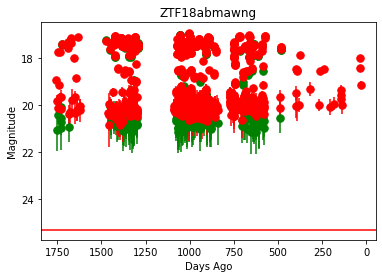

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abmawng/
https://alerce.online/object/ZTF18abmawng


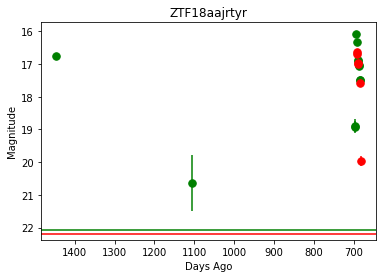

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aajrtyr/
https://alerce.online/object/ZTF18aajrtyr


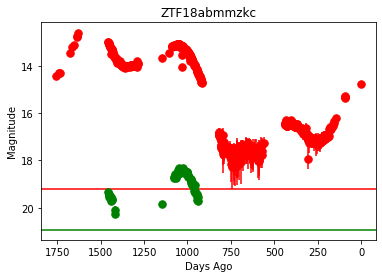

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abmmzkc/
https://alerce.online/object/ZTF18abmmzkc


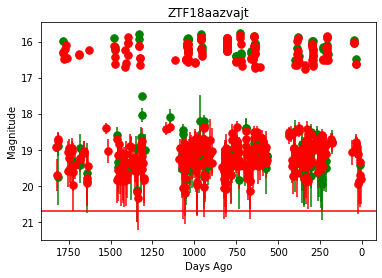

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aazvajt/
https://alerce.online/object/ZTF18aazvajt


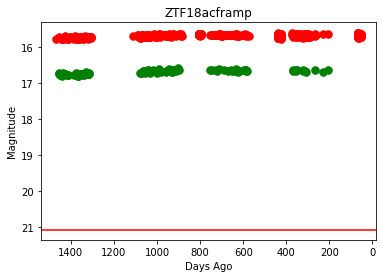

https://lasair-ztf.lsst.ac.uk/objects/ZTF18acframp/
https://alerce.online/object/ZTF18acframp


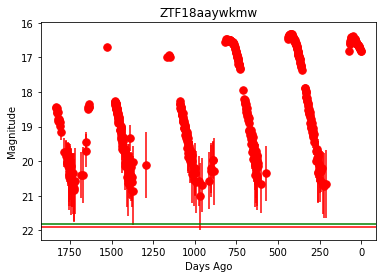

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aaywkmw/
https://alerce.online/object/ZTF18aaywkmw


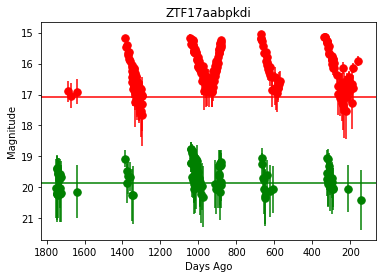

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aabpkdi/
https://alerce.online/object/ZTF17aabpkdi


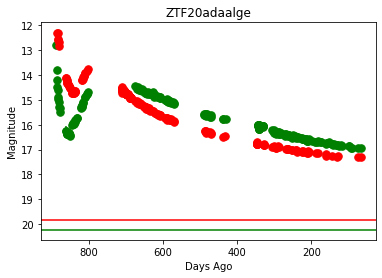

https://lasair-ztf.lsst.ac.uk/objects/ZTF20adaalge/
https://alerce.online/object/ZTF20adaalge


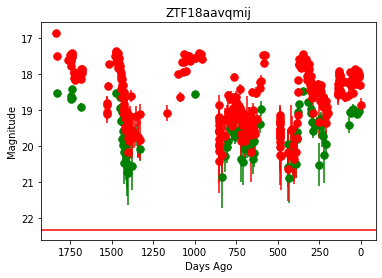

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aavqmij/
https://alerce.online/object/ZTF18aavqmij


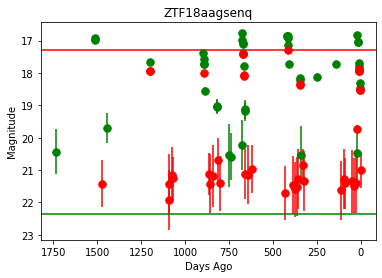

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aagsenq/
https://alerce.online/object/ZTF18aagsenq


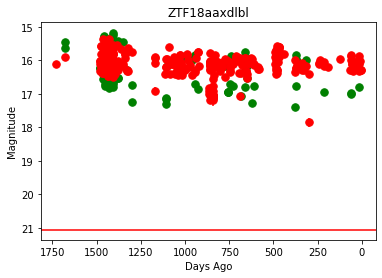

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aaxdlbl/
https://alerce.online/object/ZTF18aaxdlbl


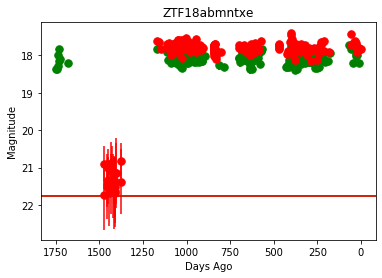

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abmntxe/
https://alerce.online/object/ZTF18abmntxe


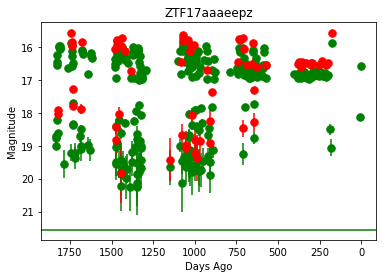

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aaaeepz/
https://alerce.online/object/ZTF17aaaeepz


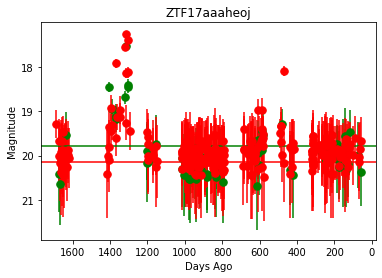

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aaaheoj/
https://alerce.online/object/ZTF17aaaheoj


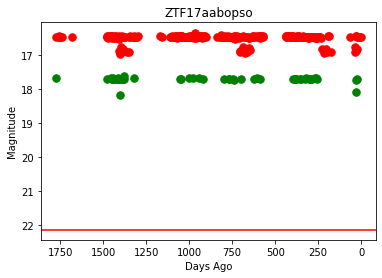

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aabopso/
https://alerce.online/object/ZTF17aabopso


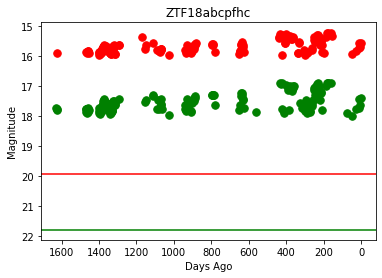

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abcpfhc/
https://alerce.online/object/ZTF18abcpfhc


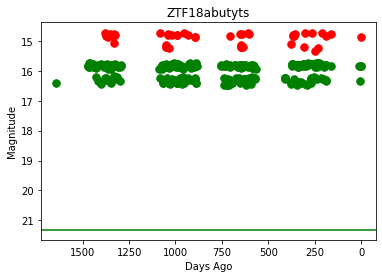

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abutyts/
https://alerce.online/object/ZTF18abutyts


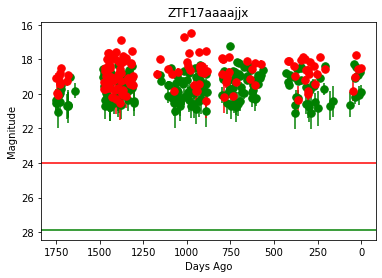

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aaaajjx/
https://alerce.online/object/ZTF17aaaajjx


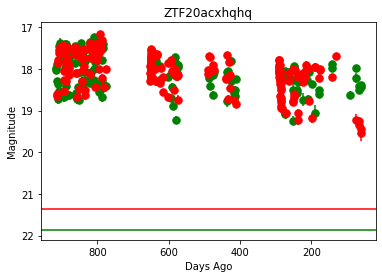

https://lasair-ztf.lsst.ac.uk/objects/ZTF20acxhqhq/
https://alerce.online/object/ZTF20acxhqhq


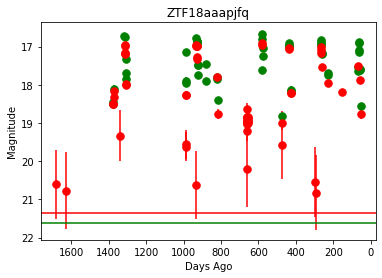

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aaapjfq/
https://alerce.online/object/ZTF18aaapjfq


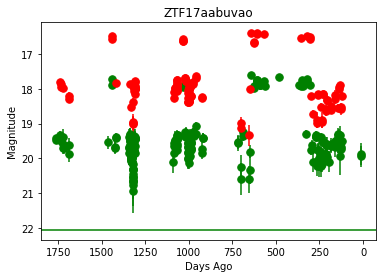

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aabuvao/
https://alerce.online/object/ZTF17aabuvao


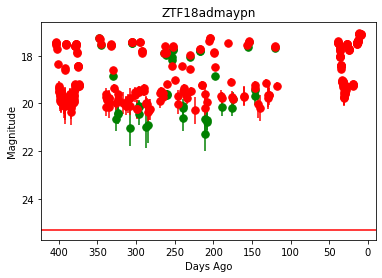

https://lasair-ztf.lsst.ac.uk/objects/ZTF18admaypn/
https://alerce.online/object/ZTF18admaypn


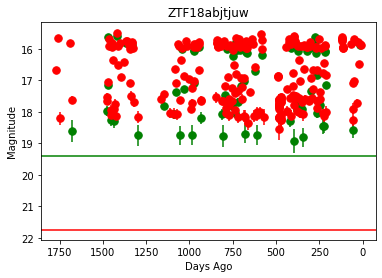

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abjtjuw/
https://alerce.online/object/ZTF18abjtjuw


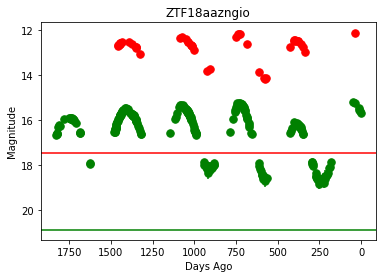

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aazngio/
https://alerce.online/object/ZTF18aazngio


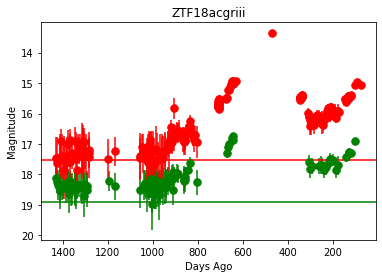

https://lasair-ztf.lsst.ac.uk/objects/ZTF18acgriii/
https://alerce.online/object/ZTF18acgriii


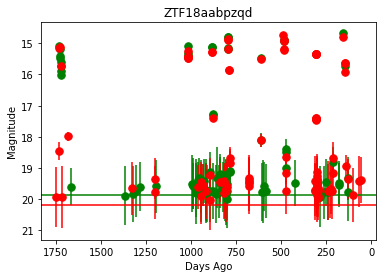

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aabpzqd/
https://alerce.online/object/ZTF18aabpzqd


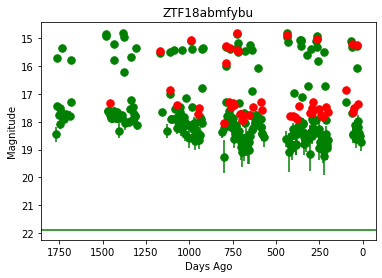

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abmfybu/
https://alerce.online/object/ZTF18abmfybu


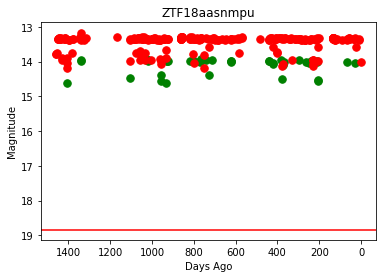

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aasnmpu/
https://alerce.online/object/ZTF18aasnmpu


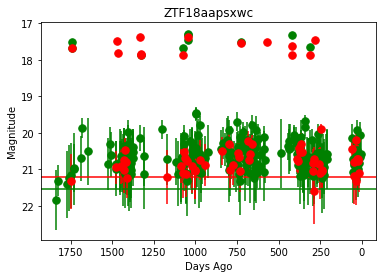

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aapsxwc/
https://alerce.online/object/ZTF18aapsxwc


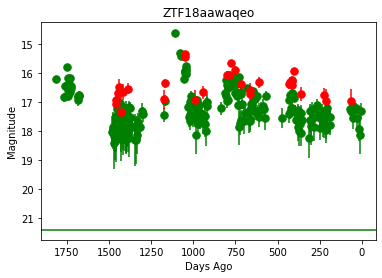

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aawaqeo/
https://alerce.online/object/ZTF18aawaqeo


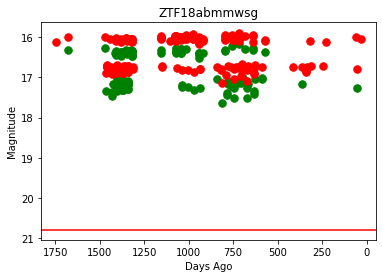

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abmmwsg/
https://alerce.online/object/ZTF18abmmwsg


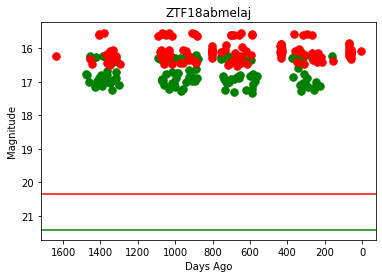

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abmelaj/
https://alerce.online/object/ZTF18abmelaj


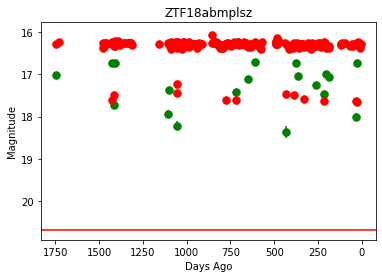

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abmplsz/
https://alerce.online/object/ZTF18abmplsz


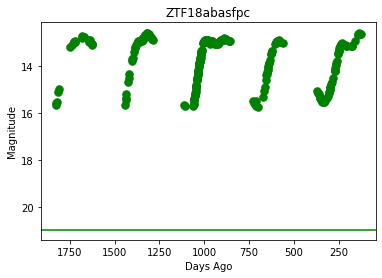

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abasfpc/
https://alerce.online/object/ZTF18abasfpc


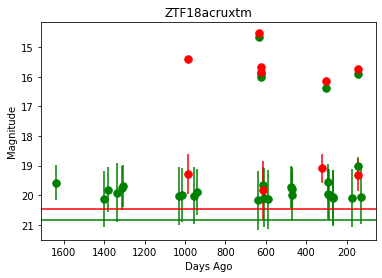

https://lasair-ztf.lsst.ac.uk/objects/ZTF18acruxtm/
https://alerce.online/object/ZTF18acruxtm


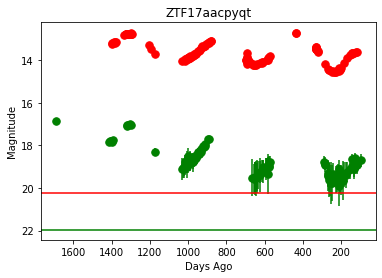

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aacpyqt/
https://alerce.online/object/ZTF17aacpyqt


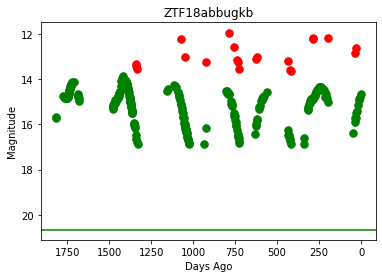

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abbugkb/
https://alerce.online/object/ZTF18abbugkb


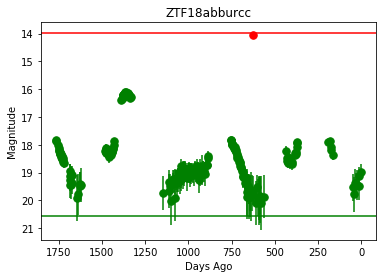

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abburcc/
https://alerce.online/object/ZTF18abburcc


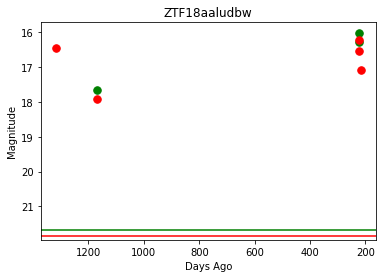

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aaludbw/
https://alerce.online/object/ZTF18aaludbw


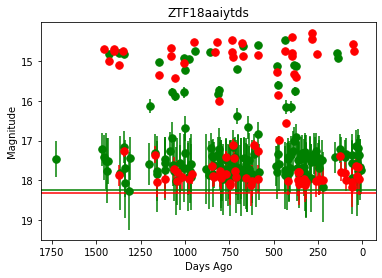

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aaiytds/
https://alerce.online/object/ZTF18aaiytds


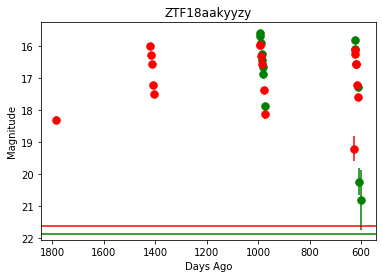

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aakyyzy/
https://alerce.online/object/ZTF18aakyyzy


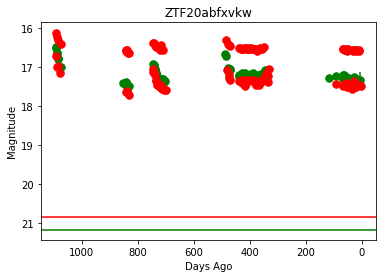

https://lasair-ztf.lsst.ac.uk/objects/ZTF20abfxvkw/
https://alerce.online/object/ZTF20abfxvkw


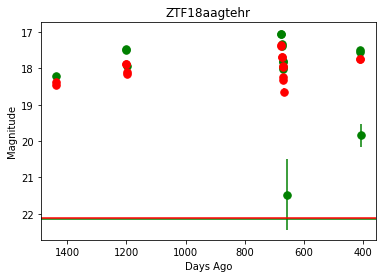

https://lasair-ztf.lsst.ac.uk/objects/ZTF18aagtehr/
https://alerce.online/object/ZTF18aagtehr


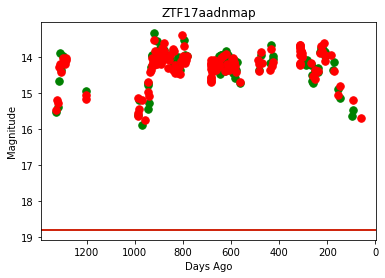

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aadnmap/
https://alerce.online/object/ZTF17aadnmap


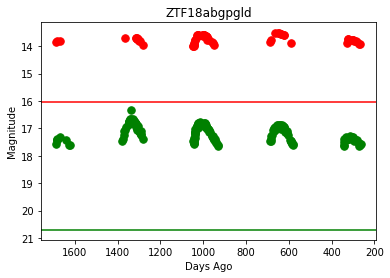

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abgpgld/
https://alerce.online/object/ZTF18abgpgld


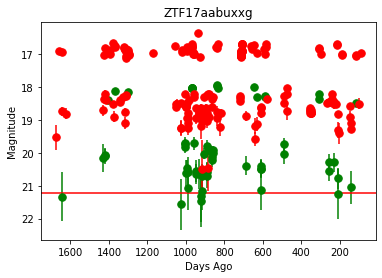

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aabuxxg/
https://alerce.online/object/ZTF17aabuxxg


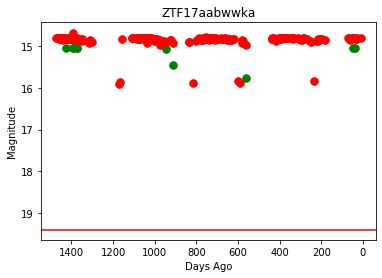

https://lasair-ztf.lsst.ac.uk/objects/ZTF17aabwwka/
https://alerce.online/object/ZTF17aabwwka


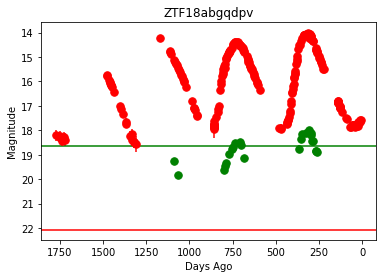

https://lasair-ztf.lsst.ac.uk/objects/ZTF18abgqdpv/
https://alerce.online/object/ZTF18abgqdpv


In [31]:
for x in candids[:50]:
    g, r = df.query(f'ztf_object_id == "{x}"')[['sgmag','srmag']].values[0]
    sub = dflc.loc[x].dropna(subset=['dc_mag'])
    if len(sub) > 2:
        ax = plot_dc_lightcurve(sub.reset_index(), x, r=r, g=g)
        print(f'https://lasair-ztf.lsst.ac.uk/objects/{x}/')
        print(f'https://alerce.online/object/{x}')

        # show_stamps(x)
    # mark_seen(conn, x)


### Pick out sources observed in 2023 within 15deg of the galactic plane

In [34]:
recent = [x for x in candids if 'ZTF23' in x]

In [37]:
df['b'] = galactic_latitude(df['ra'], df['dec'])

In [38]:
df['abs_b'] = abs(df['b'])

In [54]:
recent_candids = df[((df['ztf_object_id'].isin(recent)) & (df['abs_b'] < 15))]['ztf_object_id']

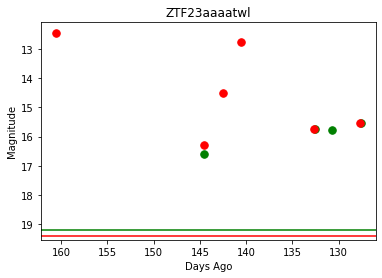

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aaaatwl/
https://alerce.online/object/ZTF23aaaatwl


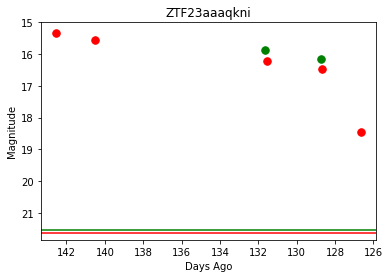

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aaaqkni/
https://alerce.online/object/ZTF23aaaqkni


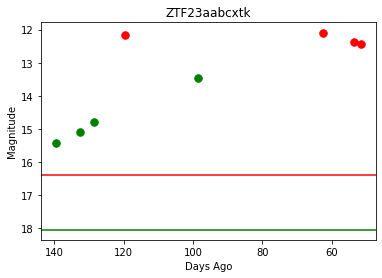

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aabcxtk/
https://alerce.online/object/ZTF23aabcxtk


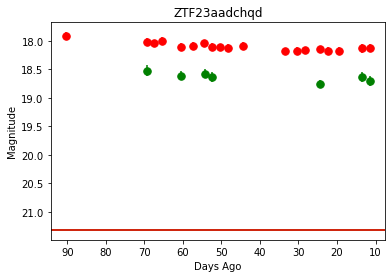

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aadchqd/
https://alerce.online/object/ZTF23aadchqd


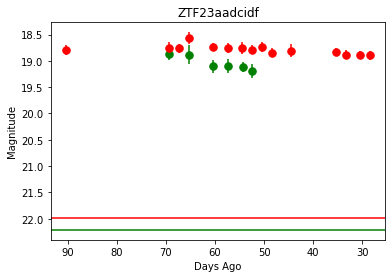

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aadcidf/
https://alerce.online/object/ZTF23aadcidf


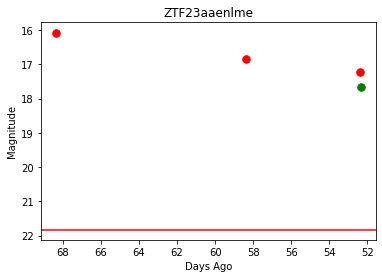

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aaenlme/
https://alerce.online/object/ZTF23aaenlme


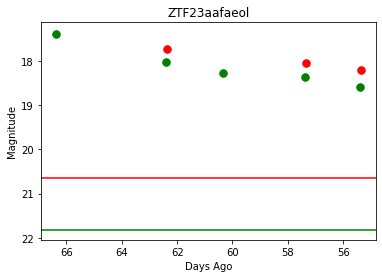

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aafaeol/
https://alerce.online/object/ZTF23aafaeol


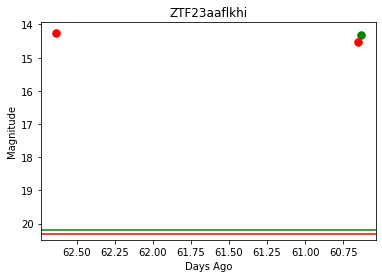

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aaflkhi/
https://alerce.online/object/ZTF23aaflkhi


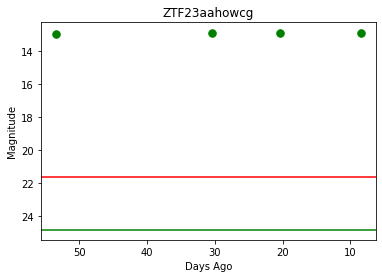

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aahowcg/
https://alerce.online/object/ZTF23aahowcg


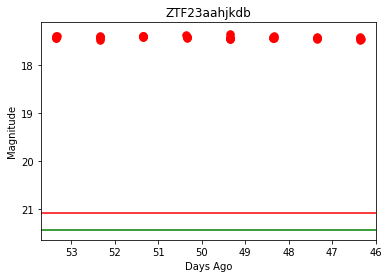

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aahjkdb/
https://alerce.online/object/ZTF23aahjkdb


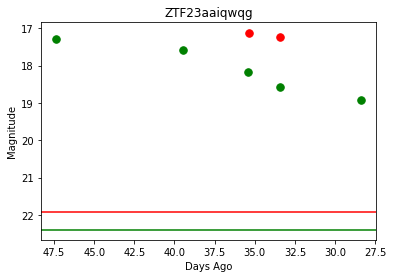

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aaiqwqg/
https://alerce.online/object/ZTF23aaiqwqg


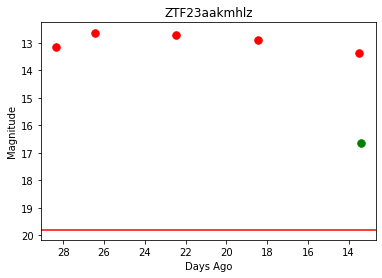

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aakmhlz/
https://alerce.online/object/ZTF23aakmhlz


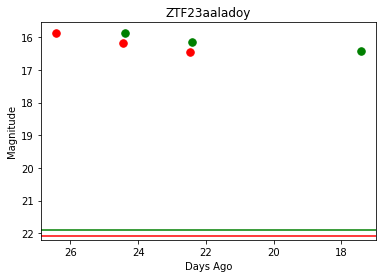

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aaladoy/
https://alerce.online/object/ZTF23aaladoy


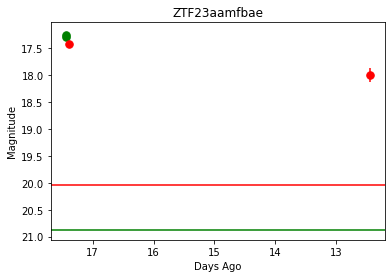

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aamfbae/
https://alerce.online/object/ZTF23aamfbae


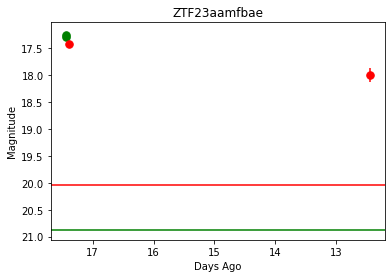

https://lasair-ztf.lsst.ac.uk/objects/ZTF23aamfbae/
https://alerce.online/object/ZTF23aamfbae


In [57]:
for x in recent_candids[:50]:
    g, r = df.query(f'ztf_object_id == "{x}"')[['sgmag','srmag']].values[0]
    sub = dflc.loc[x].dropna(subset=['dc_mag'])
    if len(sub) > 2:
        ax = plot_dc_lightcurve(sub.reset_index(), x, r=r, g=g)
        print(f'https://lasair-ztf.lsst.ac.uk/objects/{x}/')
        print(f'https://alerce.online/object/{x}')

        # show_stamps(x)
    # mark_seen(conn, x)
